# New model structure functions

Test out the adjustments to the structure function model that account for the finite box effect. 

## The model itself

The structure function is written in terms of the spatial autocorrelation 
$$
B(r) = 2 \sigma^2 \left( 1 - C \right)
$$
where the spatial autocorrelation (normalized autocovariance) is modeled as 
$$
C(r) = \exp \left[ -\ln 2 \, \left( \frac{r}{r_0} \right)^m \right]
$$
where $r_0$ is the coherence length and $m$ is the power law slope at small scales. 
This replaces the model we had previously:
$$
C(r) = \left[ 1 + \left( \frac{r}{r_0} \right)^m \right]^{-1}
$$
The advantage of the exponential version is that it makes a shaper transition from the power law growth to the flat portion. 

Note that the model autocorrelation is always positive, whereas in principle it could go between $[-1, 1]$. Negative autocorrelation can be produced by periodic fluctuations of wavelength $\lambda$ – negative peaks occur at $r = \lambda/2, 3\lambda/2, \dots$. 

The integral scale of the turbulence is given by $r_\mathrm{int} = \xi(m) r_0$ where
$$
\xi(m) = \frac{ 1} { m \, (\ln 2)^{1/m}} \, \Gamma\left(\frac{1}{m}\right) \sim 1.5
$$
The $\xi$ factor falls from 2.3 to 1.1 as $m$ rises from $2/3$ to $5/3$. 

In [1]:
def bfunc00s(r, r0, sig2, m):
    "Simple 3-parameter structure function"
    C = np.exp(-np.log(2) * (r / r0)**m)
    return 2.0 * sig2 * (1.0 - C)

The seeing is the empirical function that we fitted to the fake data.  After some manipulation, we can reduce the fitting function to:
$$
S(r; s_0, r_0) = 
\frac{ e^{-s_0 / r_0} }
{1 + (2 s_0 / r)^a}
$$
with $a = 3/2$ yielding the best fit.

In [71]:
def seeing_large_scale(s0, r0):
    return np.exp(-s0 / r0) 

def seeing_empirical(r, s0, r0, a=1.5):
    """
    Simplified version of empirical fit to B(r) reduction from seeing
    """
    return seeing_large_scale(s0, r0) / (1 + (2 * s0 / r)**a)


In [3]:
def bfunc03s(r, r0, sig2, m, s0, noise):
    "Structure function with better seeing (scale `s0`) and noise"
    return seeing_empirical(r, s0, r0) * bfunc00s(r, r0, sig2, m) + noise

Finally, we have the finite-box effect, which depends on the box size $L$ relative to the correlation length:

In [69]:
def finite_box_effect(r0, L, scale=3.6):
    return 1 - np.exp(-L / (scale * r0))

def bfunc04s(r, r0, sig2, m, s0, noise, box_size):
    "Structure function with better seeing (scale `s0`) and noise, plus finite box effect"
    boxeff = finite_box_effect(r0, box_size)
    return seeing_empirical(r, s0, r0) * bfunc00s(r, boxeff*r0, boxeff*sig2, m) + noise

# Example structure functions

In [16]:
import cmasher as cmr
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
sns.set_color_codes()
sns.set_context("talk")

Compare true and apparent structure functions:

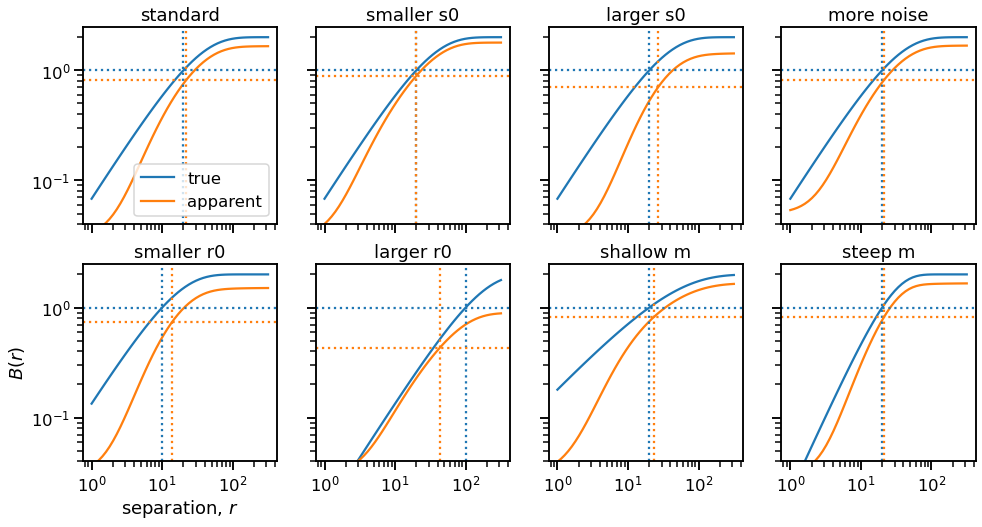

In [87]:
fig, axes = plt.subplots(
    2, 4, 
    sharex=True, sharey=True,
    figsize=(16, 8),
)
r = np.logspace(0.0, 2.5)
box_size = 212.0
sig2 = 1.0

for (r0, s0, m, noise, label), ax in zip([
        [20.0, 3.0, 1.0, 0.03, "standard"],
        [20.0, 1.5, 1.0, 0.03, "smaller s0"],
        [20.0, 6.0, 1.0, 0.03, "larger s0"],
        [20.0, 3.0, 1.0, 0.05, "more noise"],
        [10.0, 3.0, 1.0, 0.03, "smaller r0"],
        [100.0, 3.0, 1.0, 0.03, "larger r0"],
        [20.0, 3.0, 0.667, 0.03, "shallow m"],
        [20.0, 3.0, 1.4, 0.03, "steep m"],
], axes.flat):
    true_b = ax.plot(
        r, bfunc00s(r, r0, sig2, m),
        label="true",
    )
    c_true = true_b[0].get_color()
    app_b = ax.plot(
        r, 
        bfunc04s(r, r0, sig2, m, s0, noise, box_size),
        label="apparent",
    )
    c_app = app_b[0].get_color()
    
    ax.axhline(sig2, color=c_true, linestyle="dotted")
    ax.axvline(r0, color=c_true, linestyle="dotted")
    
    
    sig2_app = finite_box_effect(r0, box_size) * seeing_large_scale(s0, r0) * sig2
    rr, bb = app_b[0].get_data()
    r0_app = np.interp(sig2_app, bb, rr)
    
    ax.axhline(sig2_app, color=c_app, linestyle="dotted")
    ax.axvline(r0_app, color=c_app, linestyle="dotted")
    ax.set_title(label)
axes[0, 0].legend()             
axes[-1, 0].set(
    xscale="log",
    yscale="log",
    ylim=[0.04, 2.5],
    xlabel=r"separation, $r$",
    ylabel=r"$B(r)$",
);

The "true" curve (blue) is the basic model without any instrumental effects.  The "apparent" curve includes the effects of seeing, noise, and finite box.  The true and apparent $r_0$ and $\sigma^2$ are shown by dotted lines.  The $\sigma^2$ is reduced by both effects, but $r_0$ can be increased by seeing or reduced by finite-box.